In [1]:
"""
The classic game of flappy bird. Make with python
and pygame. Features pixel perfect collision using masks :o
Date Modified:  Jul 30, 2019
Author: Tech With Tim
Estimated Work Time: 5 hours (1 just for that damn collision)
"""
import pygame
import random
import os
import time
import numpy as np
import math
import torch
import torch.nn.functional
import matplotlib.pyplot as plt
import torch.optim as opt
from torch.autograd import Variable
from sklearn.model_selection import train_test_split

import scipy.stats as st
from sklearn.datasets.samples_generator import make_blobs
from matplotlib.colors import LogNorm 
import matplotlib.cm as cm

pygame 2.0.1 (SDL 2.0.14, Python 3.8.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


D:\ComputerSoftwares\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
Agent_number_n=3;
Alpha = 0.5 #(1-0.667);

global temp_list
temp_list = []
def appen(_x_list,y):
    global temp_list
    temp_list.append(_x_list)
    
def appen_train(x_list):
    global temp_list
                
    S= max(sum(x_list),1.0);
    temp_list = []
    
    for i in range(Agent_number_n):
        temp = []
        for j in range(Agent_number_n):
            if(i!=j):
                temp.append(x_list[j])
        appen(temp,S)
    
    training_data.append(temp_list)
    training_label.append(S)
    

def read_training_data():
    for i in range(50000):
        appen_train(np.random.rand(Agent_number_n));

training_data=[]
training_label=[]
S=1.0
read_training_data();

def appen_test(x_list):
    global temp_list
                
    S= max(sum(x_list),1.0);
    temp_list = []
    
    for i in range(Agent_number_n):
        temp = []
        for j in range(Agent_number_n):
            if(i!=j):
                temp.append(x_list[j])
        appen(temp,S)
    testing_data.append(temp_list)
    testing_label.append(S)
    

def read_testing_data():
#     devided=20
#     for i1 in range(devided+1):
#         for i2 in range(i1+1):
#             for i3 in range(i2+1):
#                 appen_test(i1/devided,i2/devided,i3/devided);
    for i in range(50000):
        appen_test(np.random.rand(Agent_number_n));
                            

testing_data=[]
testing_label=[]
S=1.0
read_testing_data();

In [3]:
training_data=np.array(training_data)
training_label=np.array(training_label)
testing_data=np.array(testing_data)
testing_label=np.array(testing_label)
print(training_data)
print(testing_data)
print(training_label)
print(testing_label)

[[[0.16371014 0.96518704]
  [0.78313502 0.96518704]
  [0.78313502 0.16371014]]

 [[0.59477193 0.48187925]
  [0.88650986 0.48187925]
  [0.88650986 0.59477193]]

 [[0.86035231 0.08810826]
  [0.43083429 0.08810826]
  [0.43083429 0.86035231]]

 ...

 [[0.83437973 0.30248598]
  [0.15436716 0.30248598]
  [0.15436716 0.83437973]]

 [[0.52361337 0.37344769]
  [0.73010519 0.37344769]
  [0.73010519 0.52361337]]

 [[0.9645672  0.68817152]
  [0.08491066 0.68817152]
  [0.08491066 0.9645672 ]]]
[[[0.64163588 0.84155615]
  [0.96483659 0.84155615]
  [0.96483659 0.64163588]]

 [[0.74052946 0.62253511]
  [0.43778308 0.62253511]
  [0.43778308 0.74052946]]

 [[0.76814409 0.79053885]
  [0.21736123 0.79053885]
  [0.21736123 0.76814409]]

 ...

 [[0.9345091  0.7030138 ]
  [0.51572761 0.7030138 ]
  [0.51572761 0.9345091 ]]

 [[0.46143159 0.01156365]
  [0.97256026 0.01156365]
  [0.97256026 0.46143159]]

 [[0.40153657 0.65184302]
  [0.72137101 0.65184302]
  [0.72137101 0.40153657]]]
[1.9120322  1.96316104 1.379

In [4]:
if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"  

print(dev)


cuda:0


In [5]:
def weight_init(m):
    if isinstance(m, torch.nn.Conv2d):
        torch.nn.init.xavier_normal_(m.weight, gain=nn.init.calculate_gain('relu'))
        torch.nn.init.zeros_(m.bias)
    elif isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_normal_(m.weight)
        torch.nn.init.zeros_(m.bias)
        

class Net(torch.nn.Module):
    def __init__(self):

        super(Net, self).__init__()

        num_input = Agent_number_n-1
        num_hidden = 10
        num_output = 1

        self.hidden_0 = torch.nn.Linear(num_input, num_hidden)
        self.hidden_1 = torch.nn.Linear(num_hidden, num_hidden)
        self.output_allocation = torch.nn.Linear(num_hidden, num_output)

    def calculate(self, value_list):
        h1 = torch.relu_(self.hidden_0(value_list))
        h2 = torch.relu_(self.hidden_1(h1))
        h = torch.relu(self.output_allocation(h2))
        return h

    def forward(self, input_list,input_label):
        global iteration,echo
        loss1 = 0
        loss2 = 0
        input_list = torch.from_numpy(
            np.array(input_list)).cuda().type(torch.float32)
        h_list = []
        for i in range(Agent_number_n):
            h = self.calculate(input_list[i])
            h_list.append(h)
        
        input_label = torch.from_numpy(
            np.array(input_label)).cuda().type(torch.float32)
        sum_h = torch.sum(torch.cat(h_list)).cuda()
        
        
        loss1 = torch.where((Agent_number_n-1)*input_label>sum_h,
                        torch.square((Agent_number_n-1)*input_label-sum_h),
                        torch.zeros(1).cuda()
                      )

        loss2 = torch.where((Agent_number_n-Alpha)*input_label<sum_h,
                        torch.square(sum_h-(Agent_number_n-Alpha)*input_label),
                        torch.zeros(1).cuda()
                      )
                      

        return loss1,loss2,h_list

In [6]:
random.seed(2000)
torch.manual_seed(256)
net  = Net()
net.apply(weight_init)

net = torch.load("save/Deep_learning_small_3")
net.to(dev)

Net(
  (hidden_0): Linear(in_features=2, out_features=10, bias=True)
  (hidden_1): Linear(in_features=10, out_features=10, bias=True)
  (output_allocation): Linear(in_features=10, out_features=1, bias=True)
)

In [7]:
#optimizer = opt.RMSprop(net.parameters(), lr=0.00001)
#optimizer = opt.SGD(net.parameters(), lr=0.00001)
optimizer = opt.Adam(net.parameters(), lr=0.00005)

batch_size = 64
echo = 5

In [8]:
for iteration in range(int(echo)):
    # offender_types = []
    # defender_types = []
    
    
    X_train_list = []
    temp_number = 0
    total_batch_loss = 0 
    while(temp_number<len(training_data)-1):
        loss2_list = []
        loss1_sum = 0
        loss2_sum = 0
        denominator = 0
        for index in range(temp_number, min(batch_size+temp_number,len(training_data))):
            h_loss1,h_loss2,h_list = net(training_data[index],training_label[index])
            denominator += 1
            loss1_sum += h_loss1
            loss2_sum += h_loss2
            
        loss_sum = loss1_sum + loss2_sum
        loss = (loss_sum) / denominator 
        total_batch_loss +=float(loss_sum)
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        temp_number = index
        
        if(random.random()<=0.01):
            print(temp_number,loss,float(loss1_sum),float(loss2_sum))


    print("batch iteration", iteration)
    print("batch_loss: %.2f " % (total_batch_loss/len(training_data)))
    
    print()
    print()

3024 tensor([0.0004], device='cuda:0', grad_fn=<DivBackward0>) 0.008322054520249367 0.017346136271953583
4347 tensor([0.0007], device='cuda:0', grad_fn=<DivBackward0>) 0.004812747705727816 0.03874523937702179
8883 tensor([0.0010], device='cuda:0', grad_fn=<DivBackward0>) 0.052522581070661545 0.01027033943682909
13104 tensor([0.0014], device='cuda:0', grad_fn=<DivBackward0>) 0.07835227996110916 0.009111556224524975
16128 tensor([0.0010], device='cuda:0', grad_fn=<DivBackward0>) 0.03570135682821274 0.02821424975991249
25011 tensor([0.0004], device='cuda:0', grad_fn=<DivBackward0>) 0.009376266039907932 0.01579222083091736
35091 tensor([0.0004], device='cuda:0', grad_fn=<DivBackward0>) 0.010250493884086609 0.01234855130314827
36351 tensor([0.0004], device='cuda:0', grad_fn=<DivBackward0>) 0.0058718654327094555 0.017788412049412727
36666 tensor([0.0008], device='cuda:0', grad_fn=<DivBackward0>) 0.025983884930610657 0.023914970457553864
batch iteration 0
batch_loss: 0.00 


5985 tensor([0.00

In [9]:
torch.save(net, "save/Deep_learning_small_3")

In [10]:
denominator = 0
result_list = []
for index in range(len(testing_data)):
    h_list = []
    for i in range(Agent_number_n):
        h = net.calculate(torch.tensor(testing_data[index][i]).cuda().type(torch.float32))
        h_list.append(float(h))
    
    #print(sum(h_list),h_list,sum(h_list)/testing_label[index])
    result_list.append(sum(h_list)/testing_label[index])
    



In [11]:
print(max(result_list),min(result_list),max(result_list)-min(result_list))

2.603384554386139 1.6872694492340088 0.9161151051521301


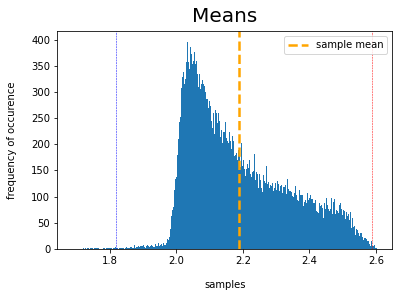

In [12]:
plt.hist(result_list,bins=500)

plt.title("Means", y=1.015, fontsize=20)
plt.axvline(x=sum(result_list)/len(result_list), linestyle='--', linewidth=2.5, label="sample mean", c='orange')
plt.xlabel("samples", labelpad=14)
plt.ylabel("frequency of occurence", labelpad=14)
plt.legend();

result_list.sort()

plt.axvline(x=result_list[int(len(result_list)*0.001)], linestyle='--', linewidth=0.5, label="0.1%", c='b')
plt.axvline(x=result_list[int(len(result_list)*0.999)], linestyle='--', linewidth=0.5, label="99%", c='r')


plt.show()

In [13]:
from torchsummary import summary

In [14]:
#summary( net(training_data[index],training_label[index]),input_size=(2))